In [1]:
import warnings
warnings.simplefilter("ignore")
#
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
import os
#
import time
import datetime
import statsmodels.api as sm
import statsmodels.tools.eval_measures as smte
from cmocean import cm as cmo
import xarray as xr
import paramiko
import numpy as np
import pandas as pd
from netCDF4 import num2date
from netCDF4 import Dataset as NetCDFFile
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import matplotlib.path as mpath
from matplotlib.colors import rgb2hex
from mpl_toolkits.basemap import Basemap
%matplotlib inline
#
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
#
from cdo import *
cdo=Cdo()

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [3]:
if os.path.exists("format.py") == False:
    os.system("ln -s ../../../anl/sample/format.py")
from format import *
mons=Mon_Name().Mon()

In [4]:
def make_colorpalet(colorname="viridis",levels=[10,30,60,70,90]):
    # https://hackmd.io/@h2tg95D2RP2ed-D8u-49Mg/S1moBqaRr
    white="#ffffff"
    lightcyan="#E0FFFF"
    paleturquoise="#AFEEEE"
#    color_code=[paleturquoise,lightcyan,white]
    color_code=[paleturquoise,white]
    num = len(levels)-len(color_code)+1
    color_code.extend(get_color_code(colorname,num)[:])

    # カラーマップ作成(→ 1)
    cmap, norm = mc.from_levels_and_colors(levels,color_code,extend="both")
    
    return cmap, norm 

def get_color_code(cname,num):
    cmap = cm.get_cmap(cname,num)

    code_list =[]
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
#        print(rgb2hex(rgb))
        code_list.append(rgb2hex(rgb))

    return code_list

# monitor
- [monitor](http://isotope.iis.u-tokyo.ac.jp/~kanon/miroc/miroc5-iso/monitor/jra25.gndg_monitoring.html)

In [5]:
z500r_longname, z500r_unit, z500r_levels, z500r_cmap, z500r_norm  = Variables().z500("raw")

In [6]:
tmax=10957
lonmin=0
lonmax=360
latmin=-90
latmax=-20
latmax2=-60
nlons=128
nlats=25
nlats2=18
numeof=10
infile="z500"

In [7]:
days=[0]
daytot=0
for yr in range(1981,2010):
    if yr%4 == 0:
        daytot=daytot+366
        days.append(daytot)
    else:
        daytot=daytot+365
        days.append(daytot)      

## Making daily climatology

In [8]:
if os.path.exists(infile) == False:
    os.system("ln -s ../cat/1dy/"+infile)
if os.path.exists(infile+".nc") == False:    
    os.system("ngtcf "+infile)

In [9]:
if os.path.exists(infile+"daymean.nc") == False:
    cdo.settunits ('-days -settaxis,1981-01-01,12:00,1day', 
                   input=infile+".nc",output="tmp.nc")
    os.system("mv tmp.nc "+infile+".nc")
    cdo.ydaymean(input=infile+".nc",
                output=infile+"daymean.nc")
    cdo.settunits ('-days -settaxis,1980-01-01,12:00,1day', 
                   input=infile+"daymean.nc",output="tmp.nc")
    os.system("mv tmp.nc "+infile+"daymean.nc")

## Making anomaly from climatology

In [10]:
if os.path.exists(infile+"_S90-S20_anom.nc") == False:
    cdo.sellonlatbox(str(lonmin)+","+str(lonmax)+","+str(latmin)+","+str(latmax),
                     input=infile+".nc",
                     output=infile+"_S90-S20.nc")
    cdo.sellonlatbox(str(lonmin)+","+str(lonmax)+","+str(latmin)+","+str(latmax),
                     input=infile+"daymean.nc",
                     output=infile+"daymean_S90-S20.nc")
   
    cdo.settunits ('-days -settaxis,1980-01-01,12:00,1day', 
                           input=infile+"daymean_S90-S20.nc",output="tmp.nc")
    os.system("mv tmp.nc "+infile+"daymean_S90-S20.nc")
    cdo.ydaysub(input=infile+"_S90-S20.nc "+infile+"daymean_S90-S20.nc", output=infile+"_S90-S20_anom.nc")

## Check trend

In [11]:
if os.path.exists(infile+"_S90-S20_anom_fldmean.nc") == False:
    cdo.fldmean(input=infile+"_S90-S20.nc",output=infile+"_S90-S20_fldmean.nc")
    cdo.fldmean(input=infile+"_S90-S20_anom.nc",output=infile+"_S90-S20_anom_fldmean.nc")
#
fldmean     = NetCDFFile(infile+"_S90-S20_fldmean.nc"     ).variables["zg"][:,0,0]
fldmeananom = NetCDFFile(infile+"_S90-S20_anom_fldmean.nc").variables["zg"][:,0,0]
time        = np.arange(0,tmax,1)
#
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize=(6,2))
ax1 = fig.add_subplot(2,1,1)
ax2 = ax1.twinx()
ax1.plot(    time,fldmean,
         color="black",linewidth=1, label="raw")
ax2.plot(    time,fldmeananom,
         color="red",linewidth=1, label="anom")
ax2.axhline(y=0,color="k",ls="-",linewidth=0.5)
plt.xlim([0,tmax])
plt.xlabel("Number of dayss")
plt.ylabel("z500")
#plt.legend(loc="best")          
plt.show()

## Check fields

In [12]:
def LatLon(nlons):
    dlats            = NetCDFFile(infile+"_S90-S20.nc").variables["lat"]
    dlons            = NetCDFFile(infile+"_S90-S20.nc").variables["lon"]
    dlons2=np.zeros(nlons+1)
    dlons2[0:nlons]=dlons[:]
    dlons2[nlons]=-1*dlons[0]
    flon,flat=np.meshgrid(dlons2,dlats)
    return flon, flat

def LonLat2(nlons,nlats):
    delta = 2.*np.pi/(nlons-1)
    lons = (delta*np.indices((nlats,nlons))[1,:,:])
    lats = -1*(0.5*np.pi - delta*np.indices((nlats,nlons))[0,:,:])
    return lons,lats

def xy(lons,lats,m):
    x, y = m(lons*180./np.pi, lats*180./np.pi) 
    return x,y



In [13]:
if os.path.exists(infile+"timeselmean.nc") == False:
    cdo.timselmean(tmax,
                  input=infile+"_S90-S20.nc",
                  output=infile+"_S90-S20_timeselmean.nc")
mean=NetCDFFile(infile+"_S90-S20_timeselmean.nc").variables["zg"][0,:,:]
mean2=np.zeros((nlats,nlons+1)) 
mean2[:,0:nlons]=mean[:,:]
mean2[:,nlons]=mean[:,0]
if os.path.exists(infile+"timeselmean.nc") == False:
    cdo.timselstd(tmax,
                  input=infile+"_S90-S20_anom.nc",
                  output=infile+"_S90-S20_timeselstd.nc")
std=NetCDFFile(infile+"_S90-S20_timeselstd.nc").variables["zg"][0,:,:]
std2=np.zeros((nlats,nlons+1)) 
std2[:,0:nlons]=std[:,:]
std2[:,nlons]=std[:,0]
daymean=NetCDFFile(infile+"daymean_S90-S20.nc").variables["zg"]

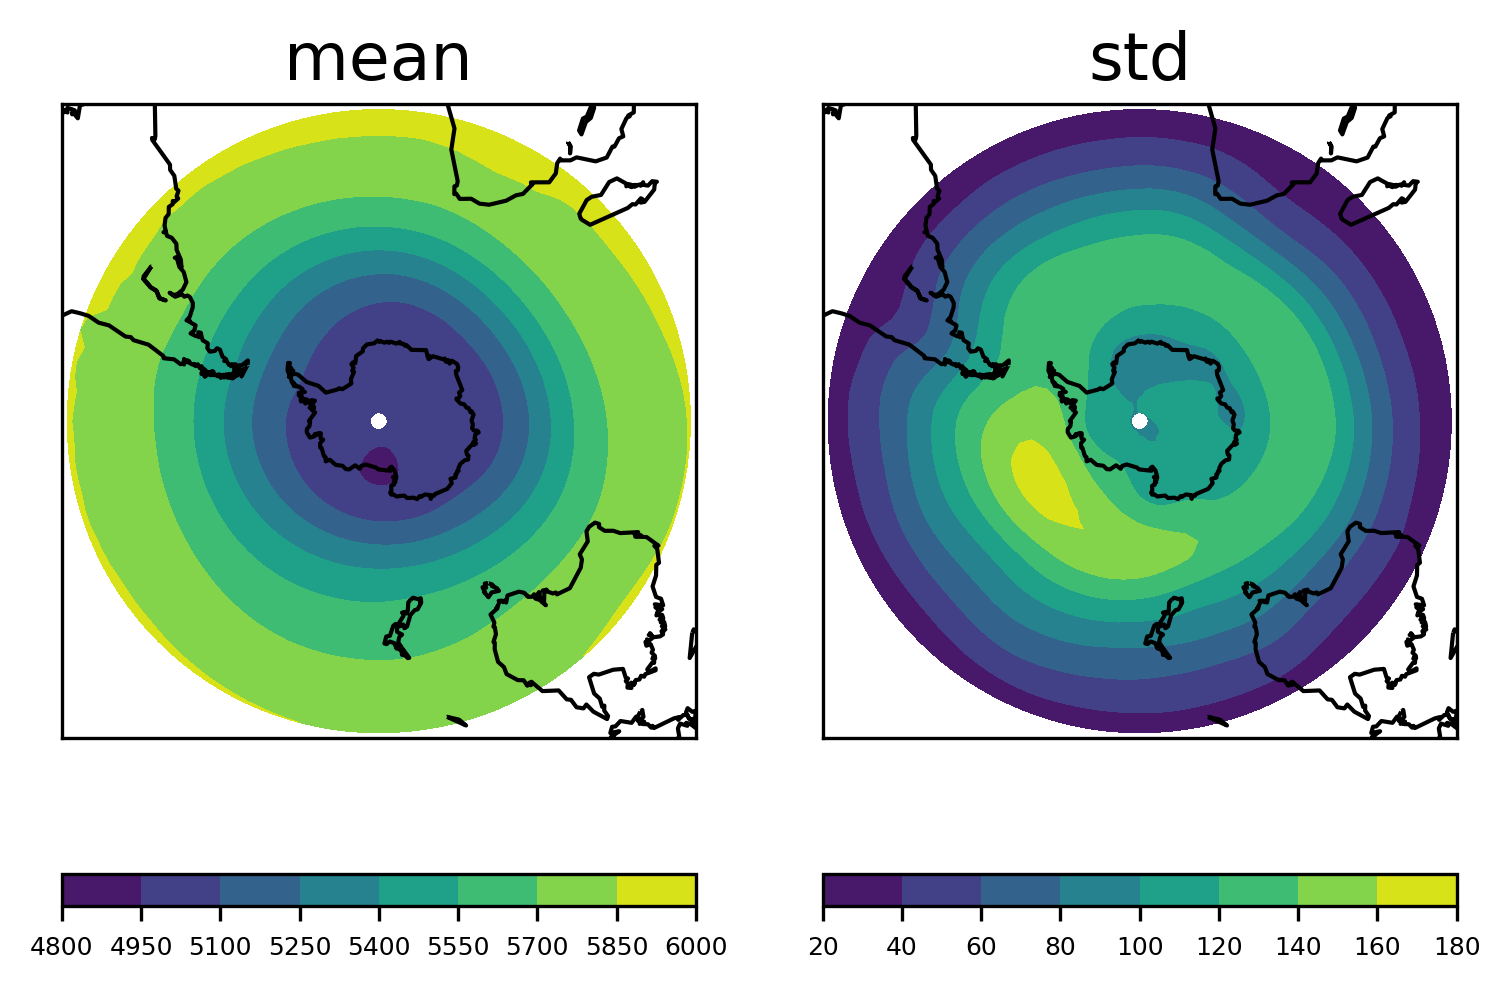

In [14]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(6,4)) 
flon,flat=LatLon(nlons)

ax = plt.subplot(1,2,1)
ax.set_title("mean", fontsize=16) 
m = Basemap(projection='spstere', lon_0=180,boundinglat=latmax) 
x,y=m(flon,flat) 
m.drawcoastlines()
cs = m.contourf(x,y,mean2)
cbar=plt.colorbar(cs, orientation='horizontal') 
cbar.ax.tick_params(labelsize=6) 

ax = plt.subplot(1,2,2)
ax.set_title("std", fontsize=16) 
m = Basemap(projection='spstere', lon_0=180,boundinglat=latmax) 
m.drawcoastlines()
cs = m.contourf(x,y,std2)
cbar=plt.colorbar(cs, orientation='horizontal') 
cbar.ax.tick_params(labelsize=6) 

fig.show()

In [15]:
tmax2=30*12
if os.path.exists("z500eofmonorg_pc_00000_detrend.nc") == False:
    os.system("ln -s ../z500mon_eof/z500eofmonorg_pc_00000_detrend.nc .")
if os.path.exists("z500eofmonorg_pc_00001_detrend.nc") == False:
    os.system("ln -s ../z500mon_eof/z500eofmonorg_pc_00001_detrend.nc .")    
if os.path.exists("z500eofmonorg_pc_00002_detrend.nc") == False:
    os.system("ln -s ../z500mon_eof/z500eofmonorg_pc_00002_detrend.nc .")    
pc = NetCDFFile("z500eofmonorg_pc_00000_detrend.nc").variables["zg"][:,0,0]
pc1 = (pc-pc.mean())/pc.std()
time2        = np.arange(0,tmax2,1)
#
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize=(6,2))
plt.plot(    time2,pc1,
         color="black",linewidth=1)
plt.axhline(y=0,color="k",ls="-",linewidth=0.5)
plt.xlim([1,tmax2])
plt.xlabel("Number of mons")
plt.ylabel("SAM-index")
#plt.legend(loc="best")          
plt.show()

In [16]:
def LatLon(nlons):
    dlats            = NetCDFFile(infile+"_S90-S20.nc").variables["lat"]
    dlons            = NetCDFFile(infile+"_S90-S20.nc").variables["lon"]
    dlons2=np.zeros(nlons+1)
    dlons2[0:nlons]=dlons[:]
    dlons2[nlons]=-1*dlons[0]
    flon,flat=np.meshgrid(dlons2,dlats)
    return flon, flat

def LonLat2(nlons,nlats):
    delta = 2.*np.pi/(nlons-1)
    lons = (delta*np.indices((nlats,nlons))[1,:,:])
    lats = -1*(0.5*np.pi - delta*np.indices((nlats,nlons))[0,:,:])
    return lons,lats

def xy(lons,lats,m):
    x, y = m(lons*180./np.pi, lats*180./np.pi) 
    return x,y



In [17]:
dlons = NetCDFFile(infile+"_S90-S20_anom.nc").variables["lon"][:] # get longitudes 
dlats = NetCDFFile(infile+"_S90-S20_anom.nc").variables["lat"][:] # get latitudes 
dlons2=np.zeros(nlons+1)
dlons2[0:nlons]=dlons[:]
dlons2[nlons]=-1*dlons[0]

In [18]:
mean=NetCDFFile("z500_S90-S20_timeselmean.nc").variables["zg"][0,:,:]
mean2=np.zeros((nlats,nlons+1)) 
mean2[:,0:nlons]=mean[:,:]
mean2[:,nlons]=mean[:,0]
std=NetCDFFile("z500_S90-S20_timeselstd.nc").variables["zg"][0,:,:]
std2=np.zeros((nlats,nlons+1)) 
std2[:,0:nlons]=std[:,:]
std2[:,nlons]=std[:,0]

In [19]:
if os.path.exists("z500variancemonorg.txt") == False:
    os.system("ln -s ../z500mon_eof/z500variancemonorg.txt .")
cor=np.zeros(numeof+1)
jj=0
for line in open("z500variancemonorg.txt", 'r'):
    jj=jj+1
    va, vb, vc, vd= line[:-1].split(' ') 
#    print(va,vb,vc,vd) 
    cor[jj]=round(float(vd),2)

In [20]:
numeof2=3
labels=["SAM","PSA1","PSA2"]

# EOFs

In [21]:
if os.path.exists("z500eofmonorg.nc") == False:
    os.system("ln -s ../z500mon_eof/z500eofmonorg.nc .")
sign=[1,1,-1,-1,1,1,-1,-1,1,1] # sign for each mode #
ff = cdo.seltimestep("1/"+str(numeof), input="z500eofmonorg.nc",
                     options='-f nc', returnCdf=True) 
# read eigen vectors
eof = ff.variables["zg"][:,:,:] # read eigen vectors
eof2=np.zeros((numeof,nlats,nlons+1)) 
eof2[:,:,0:nlons]=eof[:,:,:]
eof2[:,:,nlons]=eof[:,:,0]

In [22]:
tmax2=360
pc2=np.zeros((tmax2,numeof2))
for ii in range(numeof2):
    pc = NetCDFFile("z500eofmonorg_pc_%5.5i_detrend.nc" % (ii)).variables["zg"][:,0,0]
    pc2[:,ii] = (pc-pc.mean())/pc.std()
    eof2[ii,:,:] = eof2[ii,:,:]*pc.std()

In [23]:
z500_levels = [-100, -70,-50,-40,-30, -20, -10, -5,-1,1,5,  10,20,30,40,50,70,100]
z500_cmapname = "twilight_shifted"
z500_cmap, z500_norm = Color_Set(z500_levels, z500_cmapname)
color_code=(get_color_code(z500_cmapname,len(z500_levels)+1)[:])
mid=(len(color_code)-1)/2
color_code[int(mid)]="#ffffff"
z500_cmap, z500_norm = mc.from_levels_and_colors(z500_levels,color_code,extend="both")
z500_label = "Geopotential height (500 hPa) [m]"       

In [24]:
fig = plt.figure(figsize=(24,7)) 
lons,lats = LonLat2(nlons,nlats)
jj=0
for ii in range(numeof2):
#----draw eigen vector
    jj=jj+1
    ax = plt.subplot(1,numeof2,jj)
    m = Basemap(projection='spstere', lon_0=180, 
                boundinglat=latmax) 
    m.drawcoastlines()
    flon,flat=np.meshgrid(dlons2,dlats)
    x,y=m(flon,flat) #
    cs = m.contourf(x,y,eof2[ii,:,:]*sign[ii],   norm=z500_norm,cmap=z500_cmap,levels=z500_levels)
#    ax.text(0.015,0.9, "EOF%i" % (ii+1 ) +
    ax.text(0.015,0.9, labels[ii] +
            " ("+str(cor[ii+1])+"%)" ,
            transform=ax.transAxes, fontsize=24, 
            bbox=dict(boxstyle='square',fc='w', 
                      alpha=1.0), zorder=100)
#    plt.colorbar(cs, orientation='horizontal')
cax = fig.add_axes([0.1, -0.1, 0.8, 0.07])
art = plt.colorbar(cs, cax, orientation='horizontal')
#art.set_label(z_longname+" "+z_unit, fontsize=32) 
art.ax.tick_params(labelsize=24) 
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.3) 
plt.show()

In [25]:
if os.path.exists(infile+"eofdayproj_pc_00000.nc") == False:
#    cdo.mulc("-1.", input= "z500eofmonorg.nc", output="z500eofmon.nc")
    cdo.settunits ('-days -settaxis,1981-01-01,12:00,1day', 
                           input="z500eofmonorg.nc",output="tmp.nc")
    os.system("mv tmp.nc "+infile+"z500eofmon.nc")
    cdo.mul(input=infile+"_S90-S20_anom.nc z500eofmonorg.nc",output=infile+"_S90-S20eofproj.nc")
    cdo.eofcoeff(input="z500eofmonorg.nc "+infile+"_S90-S20_anom.nc", output=infile+"eofdayproj_pc_") 
#--read output data
ff = cdo.seltimestep("1/"+str(numeof), input=infile+"_S90-S20eofproj.nc", 
                     options='-f nc', returnCdf=True) 
# read eigen vectors
eof = ff.variables["zg"][:,:,:] # read eigen vectors
eof3=np.zeros((numeof,nlats,nlons+1)) 
eof3[:,:,0:nlons]=eof[:,:,:]
eof3[:,:,nlons]=eof[:,:,0]

In [26]:
fig = plt.figure(figsize=(24,7)) 
lons,lats = LonLat2(nlons,nlats)
jj=0
for ii in range(numeof2):
#----draw eigen vector
    jj=jj+1
    ax = plt.subplot(1,numeof2,jj)
    m = Basemap(projection='spstere', lon_0=180, 
                boundinglat=latmax) 
    m.drawcoastlines()
    flon,flat=np.meshgrid(dlons2,dlats)
    x,y=m(flon,flat) #
    cs = m.contourf(x,y,eof3[ii,:,:]*sign[ii])
#    ax.text(0.015,0.9, "EOF%i" % (ii+1 ) +
    ax.text(0.015,0.9, labels[ii] +
            " ("+str(cor[ii+1])+"%)" ,
            transform=ax.transAxes, fontsize=24, 
            bbox=dict(boxstyle='square',fc='w', 
                      alpha=1.0), zorder=100)
#    plt.colorbar(cs, orientation='horizontal')
cax = fig.add_axes([0.1, -0.1, 0.8, 0.07])
art = plt.colorbar(cs, cax, orientation='horizontal')
#art.set_label(z_longname+" "+z_unit, fontsize=32) 
art.ax.tick_params(labelsize=24) 
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.3) 
plt.show()

In [27]:
pc2=np.zeros((tmax,numeof2))
for ii in range(numeof2):
    pc = NetCDFFile(infile+"eofdayproj_pc_%5.5i.nc" % (ii)).variables["zg"][:,0,0]
    pc2[:,ii] = (pc-pc.mean())/pc.std()

In [28]:
pc2=np.zeros((tmax,numeof2))
detrend2=np.zeros((tmax,numeof2))
trend2=np.zeros((tmax,numeof2))
for ii in range(numeof2):
    if os.path.exists(infile+"eofdayproj_pc_%5.5i_trend.nc" % (ii)) == False:
        cdo.detrend(input=infile+"eofdayproj_pc_%5.5i.nc" % (ii),output=infile+"eofdayproj_pc_%5.5i_detrend.nc" % (ii))
    pc = NetCDFFile(infile+"eofdayproj_pc_%5.5i.nc" % (ii)).variables["zg"][:,0,0]
    pc2[:,ii] = (pc-pc.mean())/pc.std()
    detrend = NetCDFFile(infile+"eofdayproj_pc_%5.5i_detrend.nc" % (ii)).variables["zg"][:,0,0]
    detrend2[:,ii] = detrend/detrend.std()
    trend2[:,ii]   = pc2[:,ii]  - detrend2[:,ii]
    pc2[:,ii] = pc2[:,ii]*sign[ii]

In [29]:
fig = plt.figure(figsize=(24,30)) 
jj=0
for ii in range(numeof2):
    #----plot PC
    jj=jj+1
    ax = plt.subplot(numeof2,1,jj) #

    xx = np.arange(0,len(pc2[:,ii]),1) #
    lns3 = ax.plot(xx, pc2[:,ii], "-", ms=10, color="black", linewidth=2) 
    ax.bar(xx,pc2[:,ii],width=1)
    plt.plot(xx, trend2[:,ii], "-", ms=10, color="red", linewidth=2) 
    #
    ax.tick_params(labelsize=24)
    ax.set_xticks(days)
    ax.set_xticklabels(np.arange(1001,1031),rotation=70)
#    ax.set_ylabel('PC'+str(ii+1),fontsize=24) 
    ax.set_ylabel(labels[ii]+"-index",fontsize=32) 
    ax.set_ylim((-3.0,3.0))
    ax.axvline(x=days[10],ls='--',linewidth=1, color='k')
    ax.axvline(x=days[20],ls='--',linewidth=1, color='k')
    ax.axhline(y=1,ls='--',linewidth=1, color='k')
    ax.axhline(y=0,ls='--',linewidth=1, color='k')
    ax.axhline(y=-1,ls='--',linewidth=1, color='k')
    
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.5) 
plt.show()

In [30]:
# 日付情報
time = NetCDFFile(infile+".nc").variables["time"][:]
date_offset = datetime.datetime(1981,1,1)
date_offset.day

y = np.zeros(tmax)
m = np.zeros(tmax)
d = np.zeros(tmax)

for tt in range(tmax):
    time_data = date_offset+datetime.timedelta(days=time[tt])
    y[tt] = time_data.year
    m[tt] = time_data.month
    d[tt] = time_data.day

np.savez("sam.npz",sam=pc2[:,0], y=y, m=m, d=d)
np.savez("psa1.npz",sam=pc2[:,1], y=y, m=m, d=d)
np.savez("psa2.npz",sam=pc2[:,2], y=y, m=m, d=d)